<a href="https://colab.research.google.com/github/samsoe/mpg_notebooks/blob/master/vegetation_biomass_OVERVIEW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

bigrquery [Documentation](https://www.rdocumentation.org/packages/bigrquery/versions/1.2.0)
* billing [documentation](https://github.com/r-dbi/bigrquery/issues/366)

This is an R Notebook.  An API key needs to be generated externally and uploaded for reasons.

# Gather Tools

In [ ]:
# Package and library installation
packages_needed = c("tidyverse", "bigrquery", "httpuv", "googleAuthR", "knitr") # comma delimited vector of package names
packages_installed = packages_needed %in% rownames(installed.packages())

if (any(! packages_installed))
  install.packages(packages_needed[! packages_installed])
for (i in 1:length(packages_needed)) {
  library(packages_needed[i], character.only = T)
}

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [ ]:
# set display width
library(repr)
options(repr.plot.width=17)

# Database Connection

In [ ]:
# BigQuery API Key
bq_auth(path = "/content/mpg-data-warehouse-api_key-master.json")

In [ ]:
Sys.setenv(BIGQUERY_TEST_PROJECT = "mpg-data-warehouse")

In [ ]:
billing <- bq_test_project()

# Combined

## Query Database

In [ ]:
sql <- "SELECT 
          grid_point, 
          date, 
          year, 
          season, 
          grass_g,
          forb_g,
          pooled_g
        FROM 
          `mpg-data-warehouse.vegetation_biomass.vegetation_biomass`"

In [ ]:
tb <- bq_project_query(billing, sql)

In [ ]:
combined_result = bq_table_download(tb)

In [ ]:
class(combined_result)

[1] "tbl_df"     "tbl"        "data.frame"

## Format

In [ ]:
# convert to data frame
combined <- as.data.frame(combined_result)

In [ ]:
combined$year <- as.factor(combined$year)

In [ ]:
combined$season <- as.factor(combined$season)

In [ ]:
head(combined)

,grid_point,date,year,season,grass_g,forb_g,pooled_g
,<int>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
1,3,NA,2010,fall,NA,NA,7.3050
2,4,NA,2010,fall,NA,NA,1.5125
3,5,NA,2010,fall,NA,NA,7.4350
4,6,NA,2010,fall,NA,NA,3.9150
5,7,NA,2010,fall,NA,NA,3.1950
6,8,NA,2010,fall,NA,NA,6.4750


In [ ]:
combined$ave_g <- rowSums(combined[,c("grass_g", "forb_g", "pooled_g")], na.rm=TRUE)

In [ ]:
head(combined)

,grid_point,date,year,season,grass_g,forb_g,pooled_g,ave_g
,<int>,<date>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,3,NA,2010,fall,NA,NA,7.3050,7.3050
2,4,NA,2010,fall,NA,NA,1.5125,1.5125
3,5,NA,2010,fall,NA,NA,7.4350,7.4350
4,6,NA,2010,fall,NA,NA,3.9150,3.9150
5,7,NA,2010,fall,NA,NA,3.1950,3.1950
6,8,NA,2010,fall,NA,NA,6.4750,6.4750


## Diagnostics
* NA values

In [ ]:
summary(combined)

   grid_point         date           year        season        grass_g      
 Min.   :  2.0   Min.   :NA     2019   :309   fall  :1272   Min.   : 0.000  
 1st Qu.: 71.0   1st Qu.:NA     2012   :296   spring:1186   1st Qu.: 1.020  
 Median :157.0   Median :NA     2016   :273                 Median : 3.472  
 Mean   :182.2   Mean   :NA     2013   :261                 Mean   : 6.139  
 3rd Qu.:288.0   3rd Qu.:NA     2017   :249                 3rd Qu.: 8.868  
 Max.   :574.0   Max.   :NA     2015   :233                 Max.   :52.780  
                 NA's   :2458   (Other):837                 NA's   :1784    
     forb_g           pooled_g          ave_g       
 Min.   : 0.0000   Min.   : 0.000   Min.   : 0.000  
 1st Qu.: 0.0000   1st Qu.: 2.474   1st Qu.: 2.433  
 Median : 0.6233   Median : 5.383   Median : 5.472  
 Mean   : 2.7076   Mean   : 7.766   Mean   : 8.037  
 3rd Qu.: 3.0267   3rd Qu.:10.222   3rd Qu.:10.906  
 Max.   :49.0250   Max.   :95.249   Max.   :95.249  
 NA's   :1781

In [ ]:
combined %>% 
  filter(is.na(pooled_g)) %>% 
  kable(format = "pandoc")



 grid_point  date   year   season       grass_g       forb_g   pooled_g        ave_g
-----------  -----  -----  -------  -----------  -----------  ---------  -----------
          2  NA     2016   fall      19.7900000    1.4833333         NA   21.2733333
          2  NA     2016   spring     2.5600000    0.2200000         NA    2.7800000
          3  NA     2016   fall       7.3933333    0.3533333         NA    7.7466667
          3  NA     2016   spring     3.3233333    0.6833333         NA    4.0066667
          4  NA     2016   fall       6.9766667    1.2033333         NA    8.1800000
          4  NA     2016   spring     0.4133333    0.0000000         NA    0.4133333
          5  NA     2016   fall       2.5433333    8.6700000         NA   11.2133333
          5  NA     2016   spring     1.4400000    3.0266667         NA    4.4666667
          7  NA     2016   fall      15.6700000    0.5866667         NA   16.2566667
          7  NA     2016   spring     7.0133333    1.6733333   

In [ ]:
# # output dataframe for future use
# output = "biomass_combined-2020_04_13.csv"
# write.csv(combined, output)

# Display

### Spring

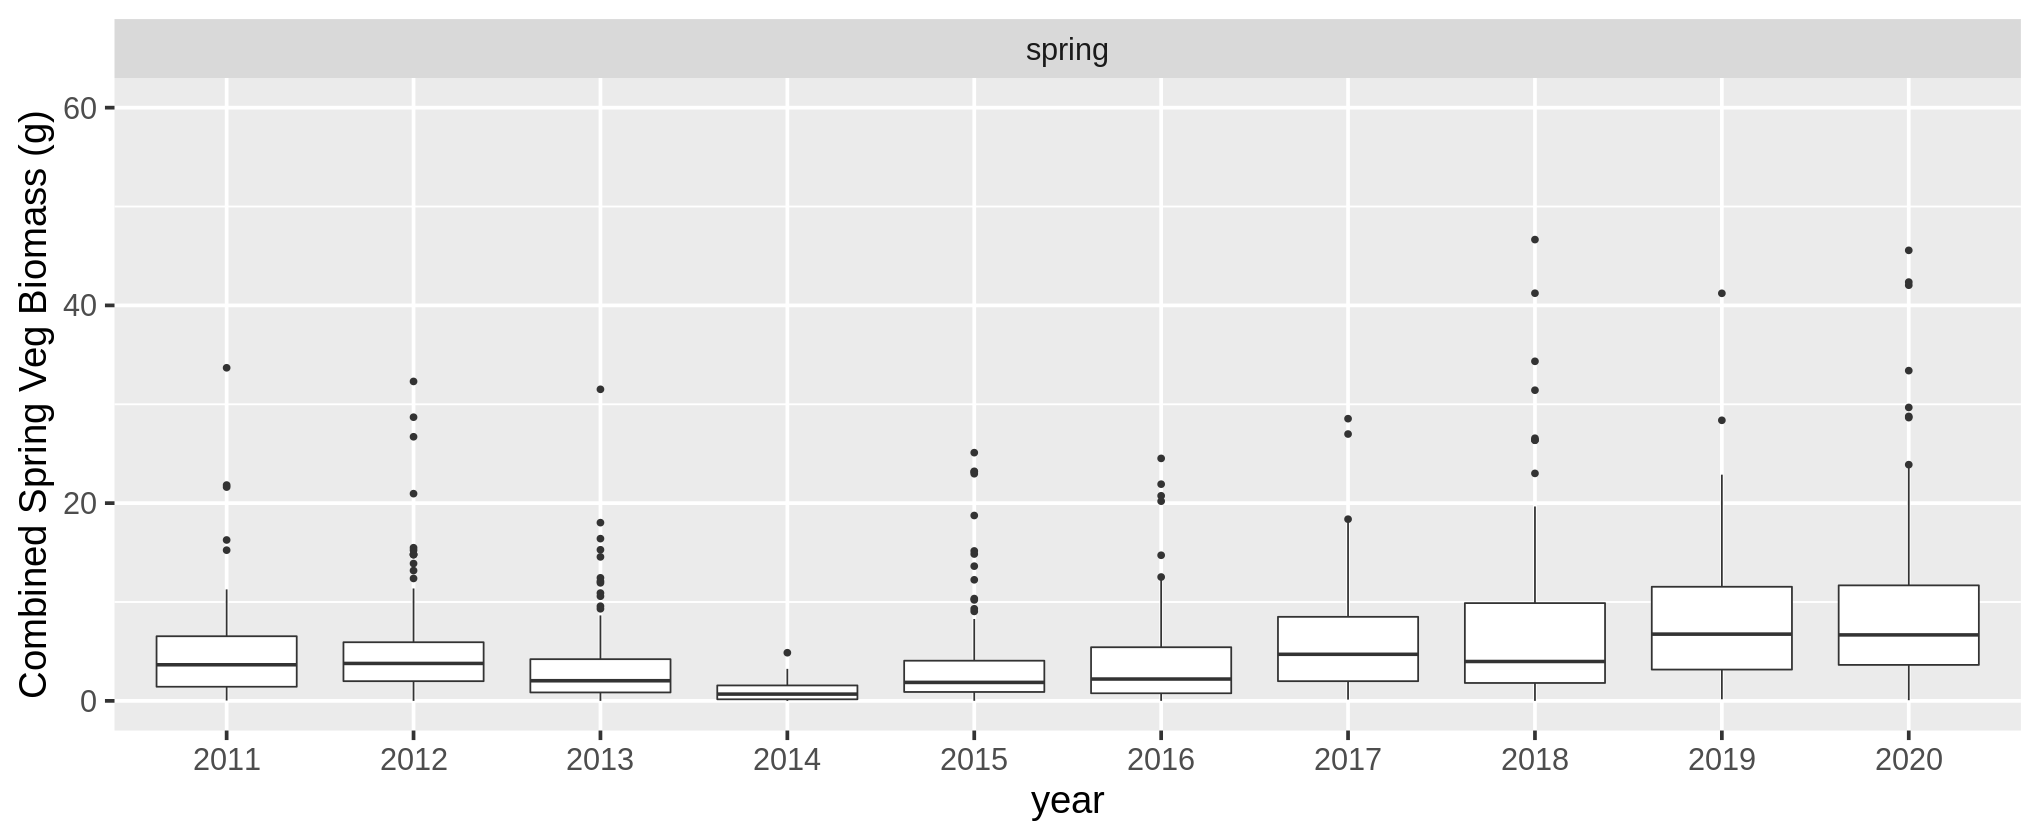

In [ ]:
p <- ggplot(data = filter(combined, season == "spring")) +
  geom_boxplot(aes(x=year, y=ave_g), na.rm=TRUE)

p +
  scale_y_continuous(name="Combined Spring Veg Biomass (g)", limits=c(0,60)) +
  theme_gray(base_size=23) +
  facet_wrap(~ season)

### Fall

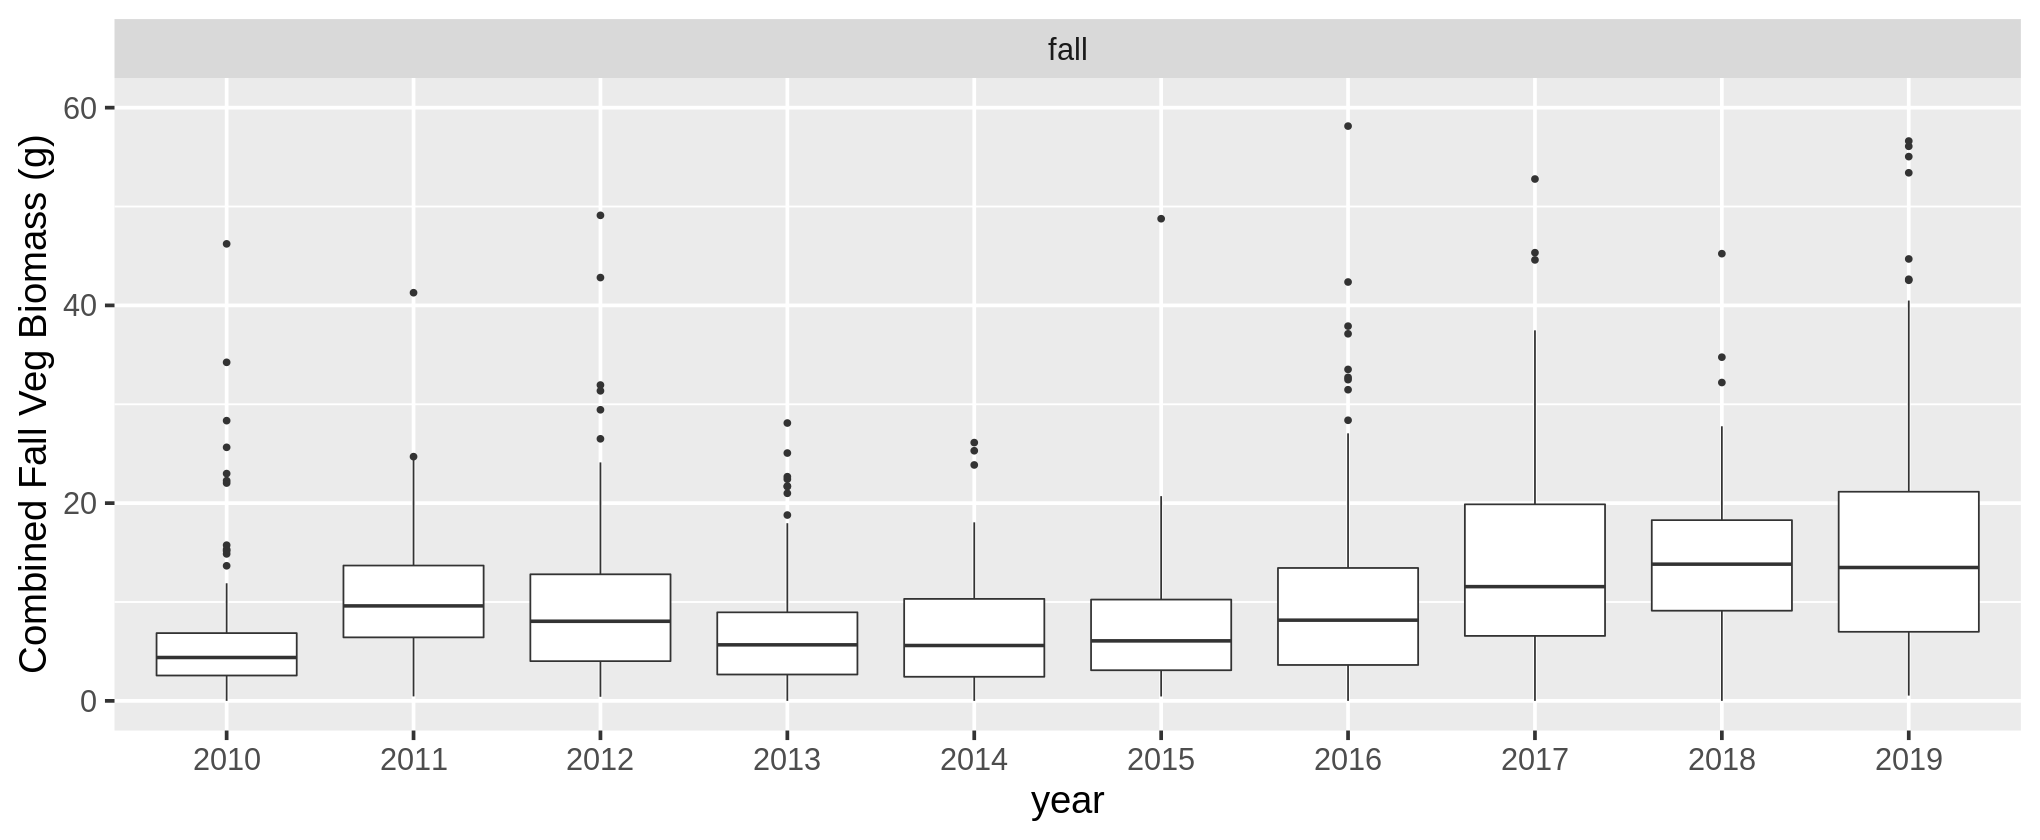

In [ ]:
p <- ggplot(data = filter(combined, season == "fall")) +
  geom_boxplot(aes(x=year, y=ave_g), na.rm=TRUE)

p +
  scale_y_continuous(name="Combined Fall Veg Biomass (g)", limits=c(0,60)) +
  theme_gray(base_size=23) +
  facet_wrap(~ season)